In [40]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [41]:
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator
from keras.api._v2.keras.applications.vgg16 import VGG16
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers import Dense, LeakyReLU, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [42]:
from typing import Tuple, List

In [43]:
tf.get_logger().setLevel('WARNING')

In [5]:
def build_transfer_learning(classes: int,
                            input_shape: Tuple[int,int,int]=(224,224,3)) -> keras.Model:
  pretrained = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg')
  pretrained.trainable = False
  
  input_layer = pretrained.input
  
  net = Dense(512, activation=LeakyReLU())(pretrained.output)
  net = Dropout(0.2)(net)
  net = Dense(256, activation=LeakyReLU())(net)
  net = Dropout(0.1)(net)
  output_layer = Dense(classes, activation='softmax')(net)
  
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
  
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [44]:
def load_df(filepaths: str) -> Tuple[pd.DataFrame, List[str]]:
  labels = [str(filepaths[i]).split('\\')[-2] for i in range(len(filepaths))]
  df_labels, labels = labels, sorted(list(set(labels)))
  df_path = pd.Series(filepaths, name='Path').astype(str)
  df_labels = pd.Series(df_labels, name='Label')
  
  df = pd.concat([df_path, df_labels], axis=1)
  df = df.sample(frac=1).reset_index(drop=True)

  return df, labels

In [45]:
def train_valid_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
  labels = df.Label.unique().tolist()
  dfs_train, dfs_valid = [], []
  
  for label in labels:
    temp_df = df[df.Label == label]
    df_train, df_valid = train_test_split(temp_df, test_size=0.2)
    dfs_train.append(df_train)
    dfs_valid.append(df_valid)

  return pd.concat(dfs_train).sample(frac=1).reset_index(drop=True),\
    pd.concat(dfs_valid).sample(frac=1).reset_index(drop=True)

In [46]:
train_dir = Path('../data/train')
train_fp = list(train_dir.glob(r'**/*.*'))

test_dir = Path('../data/test/')
test_fp = list(test_dir.glob(r'**/*.*'))

In [47]:
df_train, labels = load_df(train_fp)
df_test, _ = load_df(test_fp)
df_train, df_valid = train_valid_split(df_train)

In [48]:
print(df_test.Label.unique())
print(df_train.Label.unique())
print(df_valid.Label.unique())

['dragonfruit' 'lime' 'pear' 'strawberry' 'orange' 'durian' 'pineapple'
 'apple' 'peach' 'lemon' 'mango' 'banana']
['mango' 'pineapple' 'lemon' 'dragonfruit' 'peach' 'pear' 'durian' 'lime'
 'strawberry' 'orange' 'apple' 'banana']
['durian' 'mango' 'dragonfruit' 'orange' 'pineapple' 'apple' 'lemon'
 'lime' 'banana' 'strawberry' 'pear' 'peach']


In [49]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                             height_shift_range=0.2, rescale=1./255,
                             shear_range=0.1, zoom_range=0.2,
                             horizontal_flip=True, vertical_flip=True,
                             preprocessing_function=
                             keras.api._v2.keras.applications.vgg16.preprocess_input,
                             fill_mode='nearest')

datagen_test = ImageDataGenerator(preprocessing_function=
                                  keras.api._v2.keras.applications.vgg16.preprocess_input)

In [50]:
dataset_train = datagen.flow_from_dataframe(
  dataframe=df_train,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=True,
  seed=0)

dataset_valid = datagen.flow_from_dataframe(
  dataframe=df_valid,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=True,
  seed=0)

dataset_test = datagen_test.flow_from_dataframe(
  dataframe=df_test,
  x_col='Path',
  y_col='Label',
  target_size=(224,224),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=False)

Found 960 validated image filenames belonging to 12 classes.
Found 240 validated image filenames belonging to 12 classes.
Found 120 validated image filenames belonging to 12 classes.


In [13]:
model = build_transfer_learning(classes=len(labels), input_shape=(224,224,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

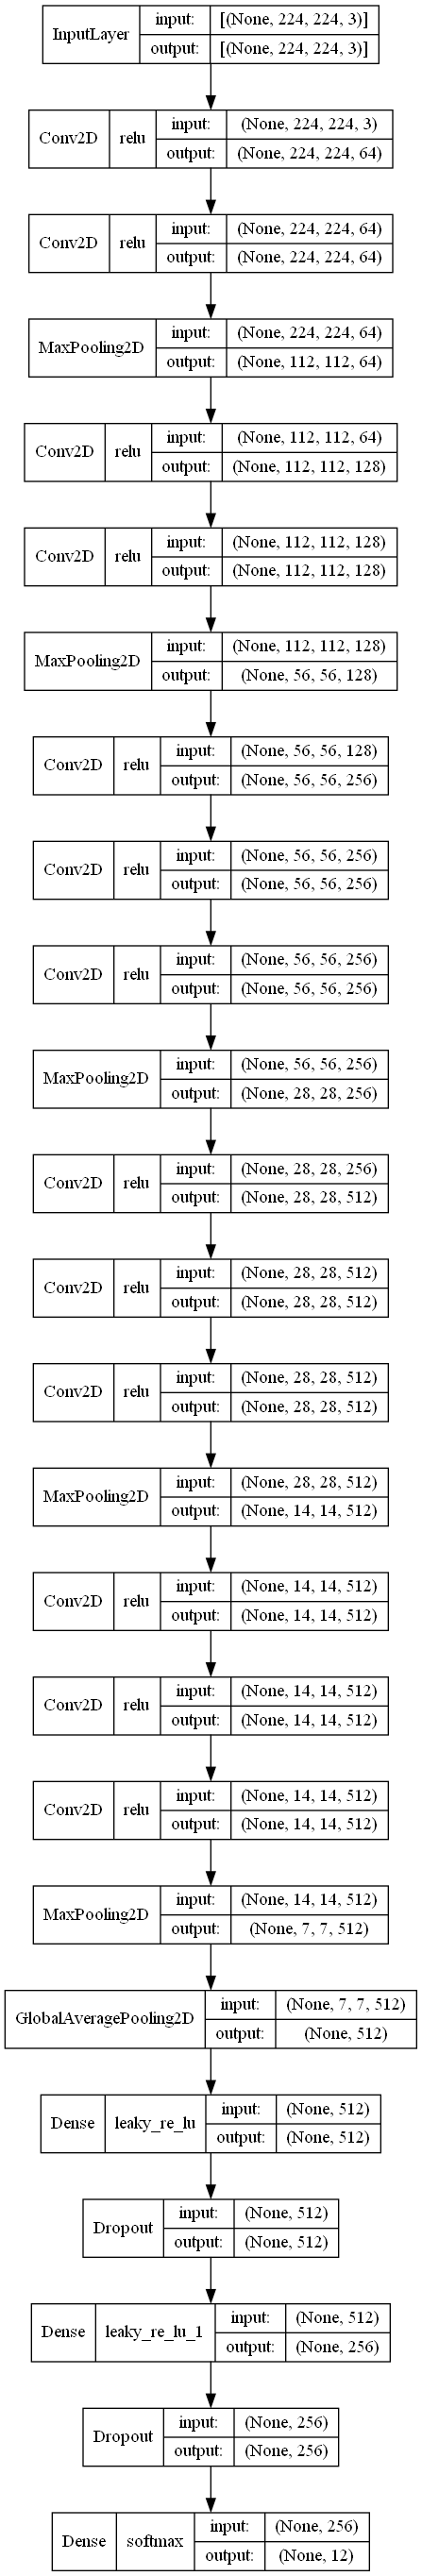

In [14]:
tf.keras.utils.plot_model(model,
                          show_layer_names=False,
                          show_shapes=True,
                          show_layer_activations=True)

In [23]:
history = model.fit(dataset_train,
                    validation_data=dataset_valid,
                    batch_size=32,
                    epochs=25,
                    callbacks=[
                      EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True)])

Epoch 1/25
19/30 [==================>...........] - ETA: 7s - loss: 0.4858 - accuracy: 0.8289

c:\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 [==============================] - 27s 910ms/step - loss: 0.4865 - accuracy: 0.8354 - val_loss: 0.6163 - val_accuracy: 0.7917
Epoch 2/25
30/30 [==============================] - 26s 859ms/step - loss: 0.4709 - accuracy: 0.8260 - val_loss: 0.8353 - val_accuracy: 0.7292
Epoch 3/25
30/30 [==============================] - 26s 856ms/step - loss: 0.4535 - accuracy: 0.8375 - val_loss: 0.7588 - val_accuracy: 0.7667
Epoch 4/25
30/30 [==============================] - 26s 873ms/step - loss: 0.4255 - accuracy: 0.8438 - val_loss: 0.6039 - val_accuracy: 0.7958
Epoch 5/25
30/30 [==============================] - 26s 886ms/step - loss: 0.3703 - accuracy: 0.8667 - val_loss: 0.7850 - val_accuracy: 0.7833
Epoch 6/25
30/30 [==============================] - 26s 871ms/step - loss: 0.3954 - accuracy: 0.8677 - val_loss: 0.6029 - val_accuracy: 0.7667
Epoch 7/25
30/30 [==============================] - 26s 873ms/step - loss: 0.3095 - accuracy: 0.9010 - val_loss: 0.6170 - val_accuracy: 0.8042
Epoch 8/25

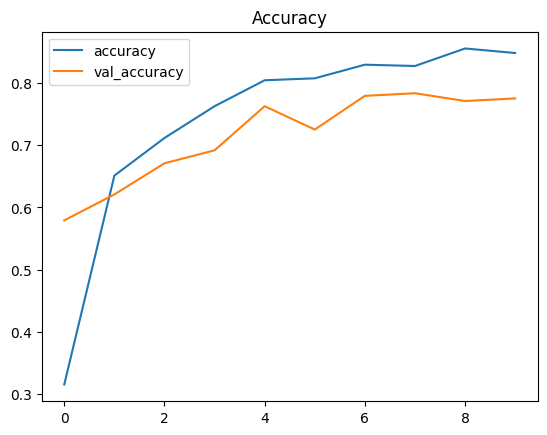

In [16]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy'); plt.show()

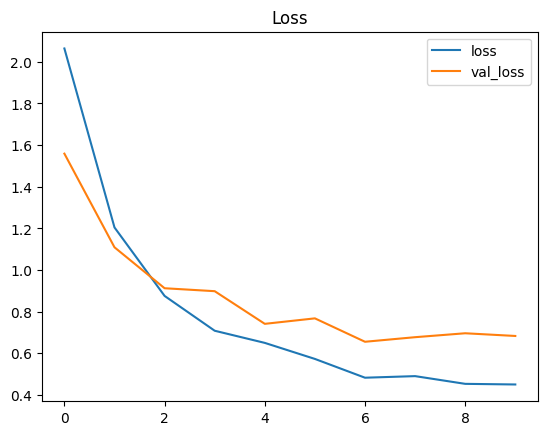

In [17]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss'); plt.show()

In [18]:
pred = model.predict(dataset_test)
pred = np.argmax(pred, axis=1)

gen_labels = (dataset_train.class_indices)
gen_labels = dict((v,k) for k,v in gen_labels.items())
pred = [gen_labels[k] for k in pred]
y_test = [gen_labels[k] for k in dataset_test.classes]

4/4 [==============================] - 4s 1s/step


In [19]:
np.unique(pred)

array(['apple', 'banana', 'dragonfruit', 'durian', 'lemon', 'lime',
       'mango', 'orange', 'peach', 'pear', 'pineapple', 'strawberry'],
      dtype='<U11')

In [20]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

       apple      0.417     0.500     0.455        10
      banana      1.000     0.800     0.889        10
 dragonfruit      0.889     0.800     0.842        10
      durian      1.000     0.900     0.947        10
       lemon      1.000     0.200     0.333        10
        lime      1.000     0.600     0.750        10
       mango      0.667     0.600     0.632        10
      orange      0.476     1.000     0.645        10
       peach      1.000     0.200     0.333        10
        pear      0.769     1.000     0.870        10
   pineapple      1.000     0.900     0.947        10
  strawberry      0.500     1.000     0.667        10

    accuracy                          0.708       120
   macro avg      0.810     0.708     0.692       120
weighted avg      0.810     0.708     0.692       120



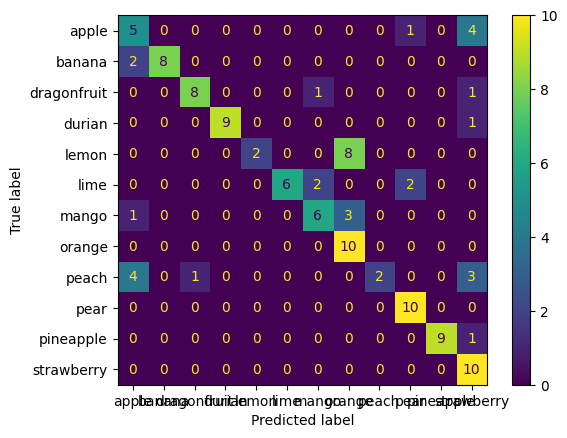

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [22]:
model.save('models/baseline_cnn_model_5', include_optimizer=True)

In [51]:
load_model = keras.models.load_model('models/baseline_cnn_model_4/', compile=False)

In [55]:
pred = load_model.predict(dataset_test)
pred = np.argmax(pred, axis=1)

gen_labels = (dataset_train.class_indices)
gen_labels = dict((v,k) for k,v in gen_labels.items())
pred = [gen_labels[k] for k in pred]
y_test = [gen_labels[k] for k in dataset_test.classes]

4/4 [==============================] - 2s 586ms/step


In [56]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

       apple      0.417     0.500     0.455        10
      banana      1.000     0.800     0.889        10
 dragonfruit      0.889     0.800     0.842        10
      durian      1.000     0.900     0.947        10
       lemon      1.000     0.200     0.333        10
        lime      1.000     0.600     0.750        10
       mango      0.667     0.600     0.632        10
      orange      0.476     1.000     0.645        10
       peach      1.000     0.200     0.333        10
        pear      0.769     1.000     0.870        10
   pineapple      1.000     0.900     0.947        10
  strawberry      0.500     1.000     0.667        10

    accuracy                          0.708       120
   macro avg      0.810     0.708     0.692       120
weighted avg      0.810     0.708     0.692       120



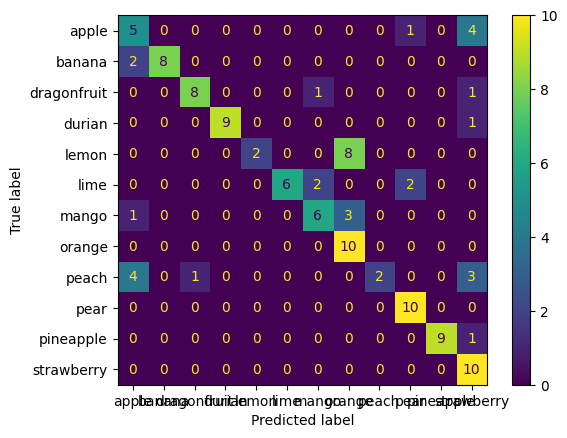

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [58]:
gen_labels

{0: 'apple',
 1: 'banana',
 2: 'dragonfruit',
 3: 'durian',
 4: 'lemon',
 5: 'lime',
 6: 'mango',
 7: 'orange',
 8: 'peach',
 9: 'pear',
 10: 'pineapple',
 11: 'strawberry'}

In [60]:
import pickle

f = open('dict_softmax/baseline_cnn_model_4.pkl', 'wb')
pickle.dump(gen_labels, f)
f.close()